# Predicting Tornado instances

In [26]:
import sys
import os

# Add the parent directory of 'src' to the Python path
sys.path.append('/Users/evansweeney/Desktop/492_project_local/cmse492_project')

# Now you can import from src
from src.windowing import WindowGenerator


import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

In [27]:
# Loading in data that we processed
df = pd.read_csv('/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/KansasStationProcessed.csv',index_col=0, parse_dates=[0])

Total samples: 52608
Training samples: 36825
Validation samples: 10522
Test samples: 5261
Number of features: 17


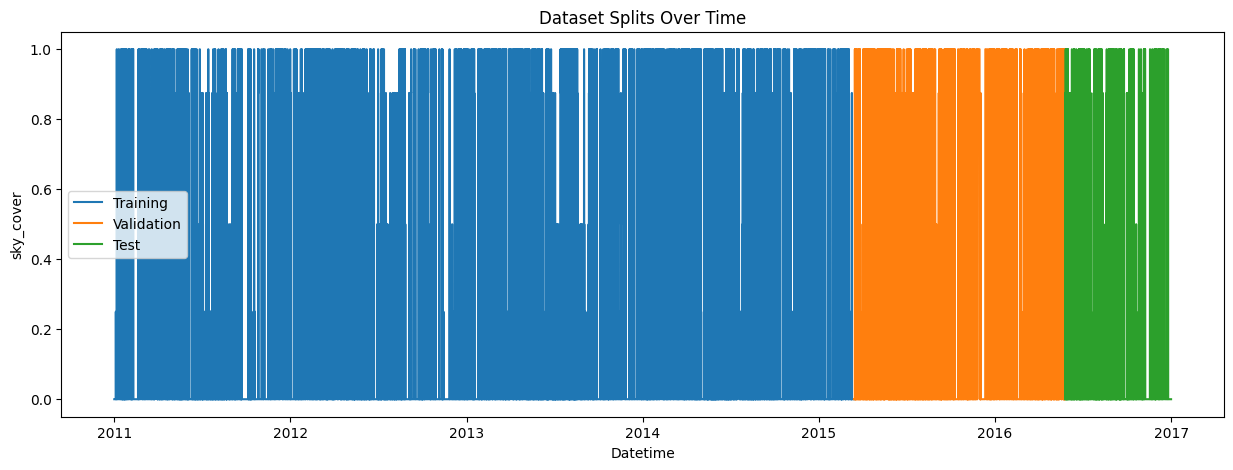

In [28]:
df = df.sort_index()

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(f"Total samples: {n}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

num_features = df.shape[1]
print(f"Number of features: {num_features}")

# Plotting temperature over time to make sure everything worked
plt.figure(figsize=(15, 5))
plt.plot(train_df.index, train_df['sky_cover'], label='Training')
plt.plot(val_df.index, val_df['sky_cover'], label='Validation')
plt.plot(test_df.index, test_df['sky_cover'], label='Test')
plt.xlabel('Datetime')
plt.ylabel('sky_cover')
plt.legend()
plt.title('Dataset Splits Over Time')
plt.show()

### RNN

In [29]:
df.columns

Index(['temperature', 'dew_point_temperature', 'wet_bulb_temperature',
       'station_level_pressure', 'sea_level_pressure', 'wind_gust',
       'relative_humidity', 'precipitation', 'visibility', 'sky_cover',
       'sky_cover_baseht', 'Wx', 'Wy', 'Day sin', 'Day cos', 'Year sin',
       'Year cos'],
      dtype='object')

In [30]:
OUT_STEPS = 24  # Number of output steps

multi_window = WindowGenerator(
    input_width=24,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['Wx']  # Specify 'sky_cover' as the label
)


In [31]:
num_features = train_df.shape[1] 
num_labels = len(multi_window.label_columns)  


In [32]:
multi_lstm_model = tf.keras.Sequential([
    # Input shape: [batch, time, features]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Output shape: [batch, OUT_STEPS * num_labels]
    tf.keras.layers.Dense(OUT_STEPS * num_labels,
                          kernel_initializer=tf.initializers.zeros()),
    # Reshape to [batch, OUT_STEPS, num_labels]
    tf.keras.layers.Reshape([OUT_STEPS, num_labels])
])


In [33]:
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min')

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(
        window.train,
        epochs=20,
        validation_data=window.val,
        callbacks=[early_stopping])
    return history


In [34]:
history = compile_and_fit(multi_lstm_model, multi_window)


Epoch 1/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 30.1730 - mean_absolute_error: 4.5132 - val_loss: 24.7425 - val_mean_absolute_error: 4.0851
Epoch 2/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 25.8380 - mean_absolute_error: 4.0799 - val_loss: 22.2430 - val_mean_absolute_error: 3.7535
Epoch 3/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 23.8550 - mean_absolute_error: 3.8472 - val_loss: 21.1308 - val_mean_absolute_error: 3.6006
Epoch 4/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 23.1245 - mean_absolute_error: 3.7587 - val_loss: 20.5569 - val_mean_absolute_error: 3.5482
Epoch 5/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 22.5929 - mean_absolute_error: 3.6999 - val_loss: 20.4651 - val_mean_absolute_error: 3.5437
Epoch 6/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 22.4273 - mean_absolute_error: 3.6767 - val_loss: 20.3529 - val_mean_absolute_error: 3.5228
Epoch 7/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 22.3411 - mean

328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.0105 - mean_absolute_error: 3.5438


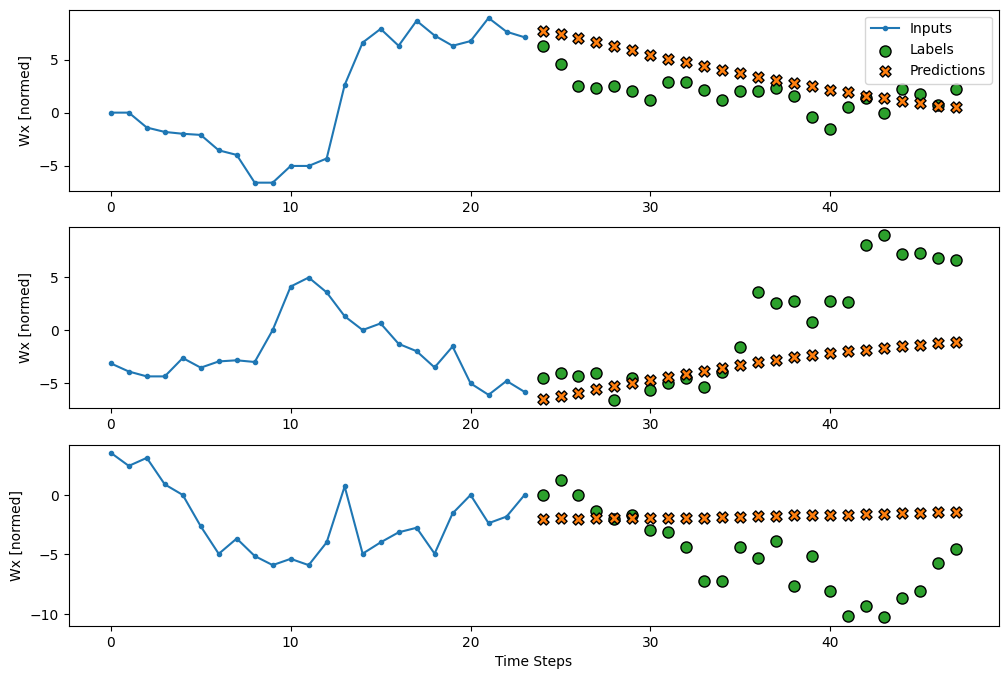

In [35]:
history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance = {}
multi_performance = {}

# Evaluate on validation data
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(
    multi_window.val, return_dict=True)

# Evaluate on test data
multi_performance['LSTM'] = multi_lstm_model.evaluate(
    multi_window.test, verbose=0, return_dict=True)

# Plot predictions for 'sky_cover'
multi_window.plot(multi_lstm_model, plot_col='Wx')

#### Testing Wx and Wy

Epoch 1/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 250.1860 - mean_absolute_error: 12.8931 - val_loss: 115.0197 - val_mean_absolute_error: 8.8685
Epoch 2/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 152.3968 - mean_absolute_error: 10.3510 - val_loss: 95.0184 - val_mean_absolute_error: 8.0429
Epoch 3/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 134.1628 - mean_absolute_error: 9.6497 - val_loss: 80.3801 - val_mean_absolute_error: 7.3604
Epoch 4/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 115.4625 - mean_absolute_error: 8.8581 - val_loss: 72.3856 - val_mean_absolute_error: 6.9630
Epoch 5/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 102.5852 - mean_absolute_error: 8.2903 - val_loss: 61.4276 - val_mean_absolute_error: 6.3863
Epoch 6/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 82.2192 - mean_absolute_error: 7.3352 - val_loss: 48.0374 - val_mean_absolute_error: 5.5667
Epoch 7/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step 

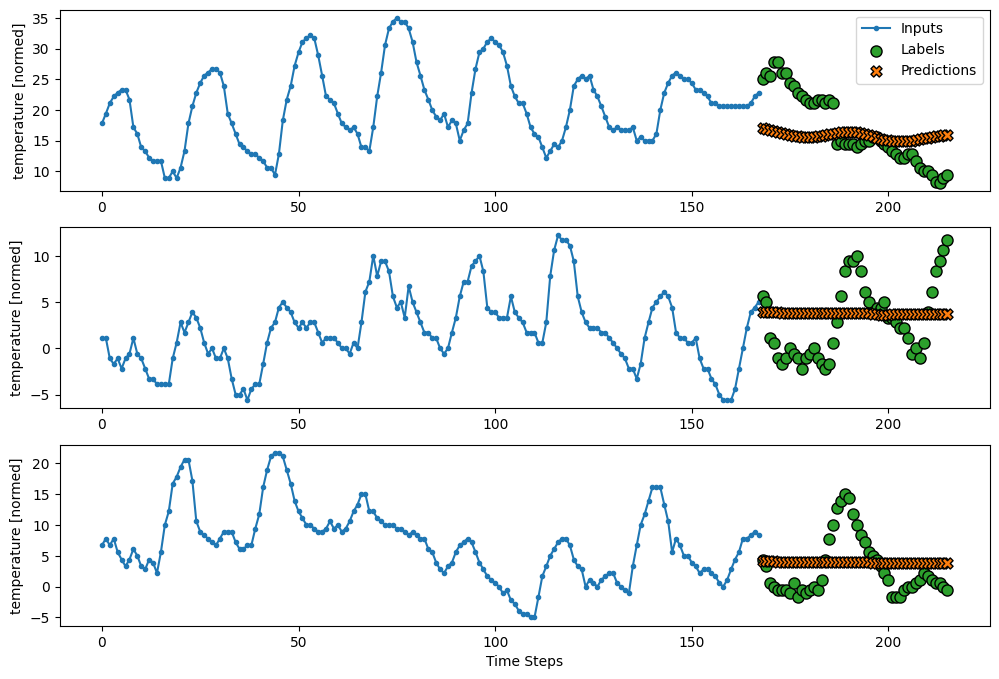

In [36]:
OUT_STEPS = 48  # Number of output steps

multi_window = WindowGenerator(
    input_width= 168,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['temperature']  # Include both 'Wx' and 'Wy' as labels
)

num_features = train_df.shape[1] 
num_labels = len(multi_window.label_columns)  # Now this is 2

multi_lstm_model = tf.keras.Sequential([
    # Input shape: [batch, time, features]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Output shape: [batch, OUT_STEPS * num_labels]
    tf.keras.layers.Dense(OUT_STEPS * num_labels,
                          kernel_initializer=tf.initializers.zeros()),
    # Reshape to [batch, OUT_STEPS, num_labels]
    tf.keras.layers.Reshape([OUT_STEPS, num_labels])
])

history = compile_and_fit(multi_lstm_model, multi_window)

# Evaluate on validation data
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(
    multi_window.val, return_dict=True)

# Evaluate on test data
multi_performance['LSTM'] = multi_lstm_model.evaluate(
    multi_window.test, verbose=0, return_dict=True)

# Plot predictions for 'Wx' and 'Wy'
multi_window.plot(multi_lstm_model, plot_col='temperature')


Epoch 1/20


/Users/evansweeney/Desktop/492_project_local/cmse492_project/tornado/lib/python3.9/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1139/1139 ━━━━━━━━━━━━━━━━━━━━ 1319s 1s/step - loss: 81.7819 - mean_absolute_error: 7.0093 - val_loss: 40.1183 - val_mean_absolute_error: 4.9200
Epoch 2/20
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 5237s 5s/step - loss: 45.6538 - mean_absolute_error: 5.4343 - val_loss: 29.7537 - val_mean_absolute_error: 4.3192
Epoch 3/20
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 1328s 1s/step - loss: 40.1591 - mean_absolute_error: 5.0514 - val_loss: 27.8979 - val_mean_absolute_error: 4.1378
Epoch 4/20
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 11729s 10s/step - loss: 34.3631 - mean_absolute_error: 4.6190 - val_loss: 25.5675 - val_mean_absolute_error: 3.8958
Epoch 5/20
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 4008s 4s/step - loss: 27.4507 - mean_absolute_error: 4.0735 - val_loss: 19.3270 - val_mean_absolute_error: 3.3313
Epoch 6/20
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 3047s 3s/step - loss: 25.3857 - mean_absolute_error: 3.9014 - val_loss: 17.7532 - val_mean_absolute_error: 3.2057
Epoch 7/20
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 8814s 8s/step - loss: 24.3428 -

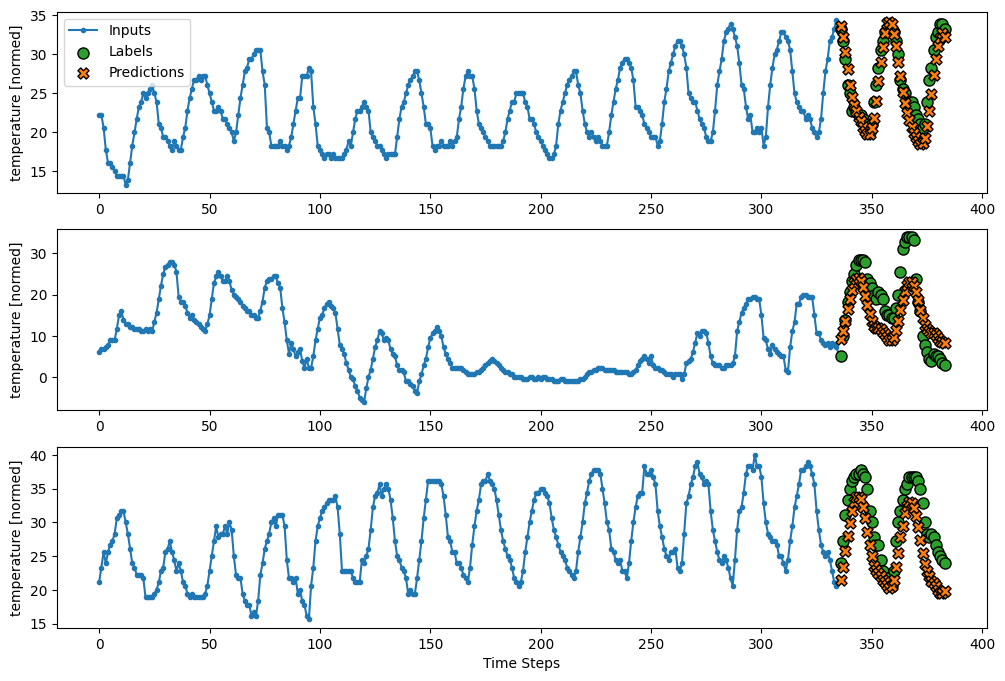

In [37]:
OUT_STEPS = 48  # Number of output steps

multi_window = WindowGenerator(
    input_width= 336,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['temperature']  # Include both 'Wx' and 'Wy' as labels
)

num_features = train_df.shape[1] 
num_labels = len(multi_window.label_columns)  # Now this is 2

from tensorflow.keras.layers import Attention, Concatenate

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="random_normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(inputs, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = inputs * a
        return tf.keras.backend.sum(output, axis=1)

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True), input_shape=[multi_window.input_width, num_features]),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    AttentionLayer(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS * num_labels, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_labels])
])


history = compile_and_fit(multi_lstm_model, multi_window)

# Evaluate on validation data
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(
    multi_window.val, return_dict=True)

# Evaluate on test data
multi_performance['LSTM'] = multi_lstm_model.evaluate(
    multi_window.test, verbose=0, return_dict=True)

# Plot predictions for 'Wx' and 'Wy'
multi_window.plot(multi_lstm_model, plot_col='temperature')


